Preparing models for 2 different approaches: tree models and neural networks.
Can bring in the latter after forming some initial hypotheses about how samples are clustered.

Input Data Files:
in ./input_data_files/
- 18Sv4 and 18Sv9 asv counts
- pr2 taxonomy which also integrates the Mixoplankton Database (Mitra et al 2023)
- exclude_samples.txt, samples to filter out of analysis
- new 18Sv4 and 18Sv9 taxonomies on pr2 5.0.0
- metadata file containing "predictor" sample features
- additional Datazoo / Calcofi website files with more environmental predictor features
    - **"High-Performance Liquid Chromatography Pigments (CalCOFI Cruise) subset 2014-2020.csv"**, contains data for cruises (not necessarily the same as the NCOG DNA/RNA collection cruises!)

outputs of this notebook:
- new frequency tables for individual asvs, individual species, and individual functional types. each formatted as such: the samples are rows/observations and the asvs are the "response" features. 
- additional response features: per sample ASV diversity scores, or diversity scores within particular categories.
- "predictor" tables subset from the metadata file, include only the allowed samples and have data for all included samples. there may be cases of NA... not sure how to resolve, may have to go col by col.

Protocols for data:
- [Main CalCofi page for protocols](https://calcofi.org/data/marine-ecosystem-data/e-dna/)
- [Protocols.io sample collection](https://www.protocols.io/view/noaa-calcofi-ocean-genomics-ncog-sample-collection-eq2lypdorlx9/v1)
- [Protocols.io DNA extraction](https://www.protocols.io/view/sterivex-dna-extraction-x54v9m1y4g3e/v2)
- [Protocols.io PCR library prep & barcoding](https://www.protocols.io/view/amplicon-library-preparation-bp2l6b4j5gqe/v1) (primers used are listed here; "quantify with the qubit" (fluorometric... so it can measure amount of DNA but not quantify sequences))
    - [PR2 primer database, try and find them](https://app.pr2-primers.org/pr2-primers/)
- [QIIME protocols on allenlab github & the other data folder](https://github.com/allenlab/QIIME2_18Sv4_ASV_protocol)

### **Reading in input files**

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
#any functions required by other notebooks have been moved here
#reimport when changing functions
from helper_functions import proportional_frequencies, shannon_index, asv_richness

In [20]:
raw_asv_freqs_18Sv9 = pd.read_csv("input_data_files/NCOG_18sV9_asv_count_tax_S.tsv", sep = "\t", index_col = 0)
raw_asv_freqs_18Sv4 = pd.read_csv("input_data_files/NCOG_18sV4_asv_count_tax.tsv", sep = "\t", index_col = 0)

raw_asv_taxonomies_18Sv9 = pd.read_csv("input_data_files/18Sv9_pr2_5.0.0_classifications.tsv", sep = "\t", index_col = 0)
raw_asv_taxonomies_18Sv4 = pd.read_csv("input_data_files/18Sv4_pr2_5.0.0_classifications.tsv", sep = "\t", index_col = 0)

pr2_taxonomies = pd.read_csv("input_data_files/pr2_version_5.0.0_taxonomy.tsv", sep = "\t")
mdb = pd.read_csv("input_data_files/trophic_type_databases/MDB_data.tsv", sep = "\t")

samples_to_exclude = pd.read_csv("input_data_files/exclude_samples.txt", skiprows=2)
sample_metadata = pd.read_csv("input_data_files/NCOG_sample_log_DNA_stvx_meta_2014-2020.csv", index_col = 0)

In [21]:
#making sure all column (sample) indices are unique - they are. diff # of ASVs and samples in each.
raw_asv_freqs_18Sv9.shape,\
(raw_asv_freqs_18Sv9.columns.value_counts() == 1).all(),\
raw_asv_freqs_18Sv4.shape,\
(raw_asv_freqs_18Sv4.columns.value_counts() == 1).all()

((50408, 1542), True, (34498, 1203), True)

In [22]:
raw_asv_freqs_18Sv4.loc[:,raw_asv_freqs_18Sv4.columns.str.contains("X201407_081.8_046.9")]

,X201407_081.8_046.9_10
Feature.ID,
00033b106a444099d17b2aa0812e6e18,0
000802b67e2ce04ac2fe019e4c7e2eb3,0
00130228e31d0a7657e07746c53d84a7,0
0018b3779c593d261b070353cd17140a,0
001d40995cee1776cd7a14fee1a7602b,0
...,...
fff4a21634d0f82626510963a24076cf,0
fff58e982f748b9f04044f6bc2fd4f21,0
fff63ac13cceabd997eea4d9e54d05e3,0


### **Filter out asv counts and rescale to proportions after removing S. pombe**

In [23]:
def sample_select(column):
    """Selects only the columns which correspond to valid sample IDs, and which are not to be excluded,
    and which do not contain only zeroes."""
    return column.name[0] == "X" \
        and column.name[1:7].isdigit() \
        and column.name not in samples_to_exclude \
        and sum(column) > 0

#18Sv4 and v9 do not have the same number of observations (samples).
sample_mask_18Sv4 = raw_asv_freqs_18Sv4.apply(sample_select, axis = 0)
sample_mask_18Sv9 = raw_asv_freqs_18Sv9.apply(sample_select, axis = 0)

#exclude all ASVs identified as internal standard Schizosaccharomyces pomb
standard_mask_18Sv4 = raw_asv_taxonomies_18Sv4["Taxon"].str.contains("pombe").apply(lambda x: not x)
standard_mask_18Sv9 = raw_asv_taxonomies_18Sv9["Taxon"].str.contains("pombe").apply(lambda x: not x)

In [24]:
(raw_asv_taxonomies_18Sv4.index == raw_asv_freqs_18Sv4.index).all(),\
(raw_asv_taxonomies_18Sv9.index == raw_asv_freqs_18Sv9.index).all()

(True, True)

In [25]:
#checking if CPL normalization is possible at all... only for 489 columns and only from 2018 - 2020? only these columns
#actually have any Spike read recovery at all. or more appropriately-- only for these 489 were any present ASVs identified
#as S. pombe, but I think we can move past doubting the taxonomy accuracy.
spike_only_18Sv4 = raw_asv_freqs_18Sv4.loc[ raw_asv_taxonomies_18Sv4["Taxon"].str.contains("pombe"), sample_mask_18Sv4 ]
spike_only_18Sv4.columns[(spike_only_18Sv4.apply(sum) > 0)]

Index(['X201802_076.7_051.0_10', 'X201802_076.7_055.0_10',
       'X201802_076.7_055.0_20', 'X201802_076.7_060.0_10',
       'X201802_076.7_060.0_20', 'X201802_080.0_051.0_10',
       'X201802_080.0_055.0_10', 'X201802_080.0_055.0_30',
       'X201802_080.0_060.0_10', 'X201802_080.0_060.0_30',
       ...
       'X202010_090.0_080.0_80', 'X202010_090.0_090.0_10',
       'X202010_090.0_090.0_60', 'X202010_090.0_120.0_10',
       'X202010_090.0_120.0_87', 'X202010_093.3_050.0_10',
       'X202010_093.3_050.0_30', 'X202010_093.3_090.0_10',
       'X202010_093.3_090.0_75', 'X202010_093.4_026.4_10'],
      dtype='object', length=489)

In [26]:
spike_only_18Sv9 = raw_asv_freqs_18Sv9.loc[ raw_asv_taxonomies_18Sv9["Taxon"].str.contains("pombe"), sample_mask_18Sv9 ]
spike_only_18Sv9.columns[(spike_only_18Sv9.apply(sum) > 0)]

Index(['X201802_076.7_051.0_10', 'X201802_076.7_055.0_10',
       'X201802_076.7_055.0_20', 'X201802_076.7_060.0_10',
       'X201802_076.7_060.0_20', 'X201802_080.0_051.0_10',
       'X201802_080.0_055.0_10', 'X201802_080.0_055.0_30',
       'X201802_080.0_060.0_10', 'X201802_080.0_060.0_30',
       ...
       'X201611_090.0_090.0_10_S', 'X201611_090.0_090.0_50_S',
       'X201611_090.0_120.0_10_S', 'X201611_090.0_120.0_87_S',
       'X201611_093.3_026.7_12_S', 'X201611_093.3_026.7_24_S',
       'X201611_093.3_045.0_33_S', 'X201611_093.3_045.0_9_S',
       'X201611_093.3_070.0_12_S', 'X201611_093.3_070.0_40_S'],
      dtype='object', length=827)

In [27]:
raw_asv_counts_18Sv4 = raw_asv_freqs_18Sv4.loc[standard_mask_18Sv4, sample_mask_18Sv4]
raw_asv_counts_18Sv9 = raw_asv_freqs_18Sv9.loc[standard_mask_18Sv9, sample_mask_18Sv9]

In [28]:
#apply row and column masks to each table, then scale proportionally along columns for proportional asv frequencies
asv_freqs_18Sv4 = raw_asv_freqs_18Sv4.loc[standard_mask_18Sv4, sample_mask_18Sv4].apply(
    proportional_frequencies, axis = 0)
asv_freqs_18Sv9 = raw_asv_freqs_18Sv9.loc[standard_mask_18Sv9, sample_mask_18Sv9].apply(
    proportional_frequencies, axis = 0)
asv_freqs_18Sv9.shape, asv_freqs_18Sv4.shape

((50407, 1485), (34496, 1145))

In [29]:
asv_taxonomies_18Sv4 = raw_asv_taxonomies_18Sv4.loc[standard_mask_18Sv4]
asv_taxonomies_18Sv9 = raw_asv_taxonomies_18Sv9.loc[standard_mask_18Sv9]
asv_taxonomies_18Sv4.shape, asv_taxonomies_18Sv9.shape

((34496, 2), (50407, 2))

In [30]:
#only 1% of the cells in both tables have a nonzero value, should only expect useful data by aggregating into
#either species or MFTs... calculate per sample diversity scores for each
#since it's the species or MFT proportions that are going to be the "response features", i don't have to transpose just yet

sum(asv_freqs_18Sv4.values.flatten() != 0) / (asv_freqs_18Sv4.index.size * asv_freqs_18Sv4.columns.size),\
sum(asv_freqs_18Sv9.values.flatten() != 0) / (asv_freqs_18Sv9.index.size * asv_freqs_18Sv9.columns.size)

(0.014492155536291532, 0.015505582537939155)

### **Environmental feature tables for 18Sv4 and 18Sv9**

Since there's different numbers of samples in each table, these won't be exactly the same.

LightGBM can handle missing values so I'll leave them in.

Not all the metadata is included in the main metadata file. Can import the ones that aren't here (example: "region" category for stations (upwelling region, etc))

In [31]:
#change index so it matches columns of the frequency tables. guessing that qiime adds the X to avoid numerical var names
sample_metadata.index = ["X" + sample_id for sample_id in sample_metadata.index]

In [32]:
samples_without_metadata_18Sv4 = asv_freqs_18Sv4.columns.drop(sample_metadata.index, errors = "ignore")
samples_without_metadata_18Sv9 = asv_freqs_18Sv9.columns.drop(sample_metadata.index, errors = "ignore")
asv_freqs_18Sv4 = asv_freqs_18Sv4.drop(samples_without_metadata_18Sv4, axis = 1)
asv_freqs_18Sv9 = asv_freqs_18Sv9.drop(samples_without_metadata_18Sv9, axis = 1)

In [33]:
#Columns that contain environmental data about a sample-- not just IDs or combos of other variables.
#variables where you wouldn't expect this to make a difference but if it does it'll be good to know: Cast_Type, Cardinal_Sta
#keep lat and long as floats, for tree regression cutoffs
useful_metadata = ["Cast_Type","Cardinal_Sta",
                   "Lat_Dec", "Lon_Dec", 
                   "Bottle_Depth", 
                   "T_degC", 
                   "Salnty", 
                   "STheta", "O2ml_L","PO4ug","SiO3ug","NO3ug","NH3ug","ChlorA","Phaeop",
                   "RecInd","MLD_Sigma"]

#not all the samples have metadata; drop the ones that don't.
#selecting sample metadata rows based on asv_freqs columns (already filtered) excludes the "samples to exclude".
env_features_18Sv4 = sample_metadata.loc[asv_freqs_18Sv4.columns, useful_metadata]
env_features_18Sv9 = sample_metadata.loc[asv_freqs_18Sv9.columns, useful_metadata]

In [34]:
#transform the date and time variables: 
#date should be year/month/season (see how many boosting trees end up splitting on month)
#should these be discrete? does lightgbm treat discrete ints differently from categorical strings?
timevars = ["year", "month", "season"]
def split_date(date_series):
    """Takes a series of (M)M/DD/YYYY objects and returns 3 series of year, month, date."""
    finished_variables = {"year":[],"month":[],"season":[]}
    seasons = ["winter", "spring", "summer", "fall"]
    for date in date_series:
        if type(date) == float and np.isnan(date):
            finished_variables["year"].append(np.nan)
            finished_variables["month"].append(np.nan)
            finished_variables["season"].append(np.nan)
        else:
            month, day, year = date.split("/")
            finished_variables["year"].append(int(year))
            finished_variables["month"].append(int(month))
            season_index = (int(month) % 12) // 3 #0, 1, 2, 3
            finished_variables["season"].append(seasons[season_index])
    return pd.DataFrame(finished_variables, index = date_series.index)

env_features_18Sv4[timevars] = split_date(sample_metadata.loc[env_features_18Sv4.index, "Date"])
env_features_18Sv9[timevars] = split_date(sample_metadata.loc[env_features_18Sv9.index, "Date"])

In [35]:
#convert time to minutes since 0000 
def time_to_mins(time):
    """Converts a H:MM, HH:MM, or (H)H:MM:SS string to "minutes since 0000". If time is nan, return nan."""
    if type(time) == float and np.isnan(time):
        return time
    hhmmss = time.split(":")
    return int(hhmmss[0]) * 60 + int(hhmmss[1]) #ignore seconds
        
env_features_18Sv4["Mins_since_0000"] = sample_metadata.loc[env_features_18Sv4.index, "Time"].apply(time_to_mins)
env_features_18Sv9["Mins_since_0000"] = sample_metadata.loc[env_features_18Sv9.index, "Time"].apply(time_to_mins)

In [36]:
env_features_18Sv4.shape

(1144, 21)

### Coverage of Spike sequences at different times/places

why does CPL table only include samples after 2018? Was a different internal standard used before 2018, or none at all?

According to plots: it's not that spikes weren't used at all before, but that they're only picked up in 18Sv4 after 2018... even so, the 18Sv9 table's 2014 values are also truncated.

In [42]:
spikes_per_sample_18Sv4 = spike_only_18Sv4.drop(samples_without_metadata_18Sv4, axis = 1).apply(sum)
spikes_per_sample_18Sv9 = spike_only_18Sv9.drop(samples_without_metadata_18Sv9, axis = 1).apply(sum)

In [43]:
(spikes_per_sample_18Sv4.index == env_features_18Sv4.index).all()

True

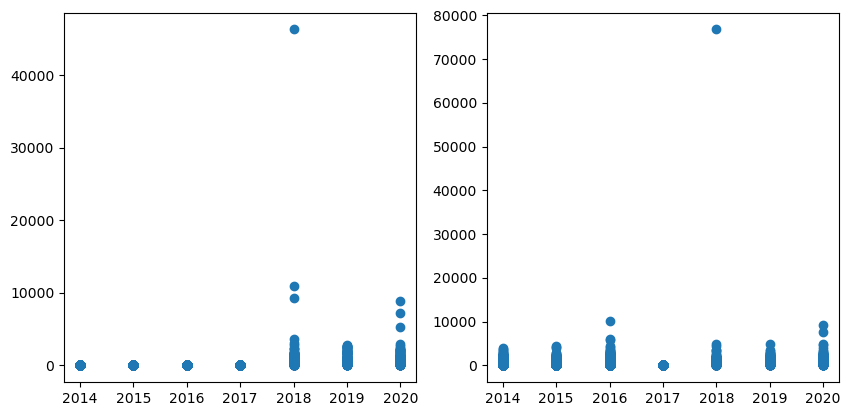

In [53]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)
ax[0].scatter(env_features_18Sv4["year"], spikes_per_sample_18Sv4)
ax[1].scatter(env_features_18Sv9["year"], spikes_per_sample_18Sv9)
plt.show()

In [44]:
env_features_18Sv4.columns

Index(['Cast_Type', 'Cardinal_Sta', 'Lat_Dec', 'Lon_Dec', 'Bottle_Depth',
       'T_degC', 'Salnty', 'STheta', 'O2ml_L', 'PO4ug', 'SiO3ug', 'NO3ug',
       'NH3ug', 'ChlorA', 'Phaeop', 'RecInd', 'MLD_Sigma', 'year', 'month',
       'season', 'Mins_since_0000'],
      dtype='object')

### **Identify ASV species and MFT, add together frequencies of ASVs tagged as the same species**

Can also take per sample diversity scores of relevant species as an additional feature.

In [17]:
#note that index doesn't count for drop-duplicates, need "species" to be its own column.
#select only the rows that don't correspond to :nucl or :plas non nuclear sequencies
#pr2_mixo_species = pr2_taxonomies.loc[pr2_taxonomies["species"].str.contains(":") == False
#                                      , ["species", "mixoplankton"]].dropna()

#nucleomorph and plastid entries are fine, seems like pr2 neive bayes classification may also include them.
pr2_mixo_species = pr2_taxonomies[["species", "mixoplankton"]].dropna()

pr2_mixo_species.columns = ["species", "MFT"]

#clean characters that could create false differences
pr2_mixo_species["species"] = pr2_mixo_species["species"].str.strip(";.")

In [18]:
mdb_mixo_species = pd.DataFrame({
    "species" : mdb["Species Name"].apply(lambda x: "_".join(x.split(" ")).strip(".") ),
    "MFT" : mdb["MFT"].str.strip("*")
})

In [19]:
combined_mixo_species = pd.concat([pr2_mixo_species, mdb_mixo_species], ignore_index=True).drop_duplicates()
combined_species_mft = combined_mixo_species["MFT"].rename(index=combined_mixo_species["species"])
combined_species_mft.size

514

In [20]:
#add the mixo column to each taxonomies object
#pr2_mft = pr2_taxonomies["mixoplankton"]
#pr2_mft.index = pr2_taxonomies["species"]
#pr2_mft.name = "MFT"
asv_taxo_mft_18Sv4 = pd.DataFrame({
    "Taxon" : asv_taxonomies_18Sv4["Taxon"],
    "Confidence" : asv_taxonomies_18Sv4["Confidence"],
    "most_specific_name" : asv_taxonomies_18Sv4["Taxon"].apply(lambda x : x.strip(";.").split(";")[-1])
})
asv_taxo_mft_18Sv9 = pd.DataFrame({
    "Taxon" : asv_taxonomies_18Sv9["Taxon"],
    "Confidence" : asv_taxonomies_18Sv9["Confidence"],
    "most_specific_name" : asv_taxonomies_18Sv9["Taxon"].apply(lambda x : x.strip(";.").split(";")[-1])
})

asv_taxo_mft_18Sv4["MFT"] = asv_taxo_mft_18Sv4["most_specific_name"].apply(
    lambda x: combined_species_mft[x] if x in combined_species_mft.index else ""
)
asv_taxo_mft_18Sv9["MFT"] = asv_taxo_mft_18Sv9["most_specific_name"].apply(
    lambda x: combined_species_mft[x] if x in combined_species_mft.index else ""
)

In [21]:
(asv_taxo_mft_18Sv4.index == asv_freqs_18Sv4.index).all(),\
(asv_taxo_mft_18Sv9.index == asv_freqs_18Sv9.index).all()

(True, True)

In [22]:
#v4 has more species classified in CM and GNCM, v9 has more in pSNCM and eSNCM - interesting.
#from here on out, should keep doing the steps for v4 and v9
for mft in ["CM", "GNCM", "pSNCM", "eSNCM"]:
    print(
        asv_taxo_mft_18Sv4.loc[asv_taxo_mft_18Sv4["MFT"] == mft].shape,
        asv_taxo_mft_18Sv9.loc[asv_taxo_mft_18Sv9["MFT"] == mft].shape,
    )
#test.loc[ ["Dinophysis_ac" in name for name in test["most_specific_name"] ] ]

(473, 4) (450, 4)
(22, 4) (7, 4)
(4, 4) (15, 4)
(84, 4) (158, 4)


In [23]:
asv_freqs_18Sv4.to_csv("01_out_asv_proportions_18Sv4.tsv", sep = "\t")
asv_freqs_18Sv9.to_csv("01_out_asv_proportions_18Sv9.tsv", sep = "\t")

In [24]:
asv_taxo_mft_18Sv4.to_csv("01_out_asv_taxo_mft_18Sv4.tsv", sep = "\t")
asv_taxo_mft_18Sv9.to_csv("01_out_asv_taxo_mft_18Sv9.tsv", sep = "\t")

In [29]:
env_features_18Sv4.to_csv("01_out_env_features_18Sv4.tsv", sep = "\t")
env_features_18Sv9.to_csv("01_out_env_features_18Sv9.tsv", sep = "\t")
#index == asv_freqs_18Sv4.columns).all()

In [30]:
(env_features_18Sv4.index == asv_freqs_18Sv4.columns).all(),\
(env_features_18Sv9.index == asv_freqs_18Sv9.columns).all()

(True, True)

In [22]:
#raw counts shouldn't include samples without metadata: 
#the metric used to eliminate some samples from asv_freqs and env_features
raw_asv_counts_18Sv4[env_features_18Sv4.index].to_csv("01_out_raw_asv_counts_18Sv4.tsv",
                                                      sep = "\t", index = True)
raw_asv_counts_18Sv9[env_features_18Sv9.index].to_csv("01_out_raw_asv_counts_18Sv9.tsv",
                                                      sep = "\t", index = True)

### Try log ratios?

### Mixo_only features

In [85]:
def add_species_asvs(series, frequencies, taxonomies):
    #series.name lists required species
    current_species = series.name
    asv_mask = taxonomies["most_specific_name"].str.match(current_species)
    matching_asvs = taxonomies.loc[asv_mask].index
    matching_asv_frequencies = frequencies.loc[matching_asvs]
    return matching_asv_frequencies.apply(sum, axis = 0)
    #assert(False)

In [88]:
mixo_species_18Sv4 = asv_taxo_mft_18Sv4.dropna()["most_specific_name"].unique()
mixo_species_18Sv9 = asv_taxo_mft_18Sv9.dropna()["most_specific_name"].unique()

#Flashweave wants variables to be listed by column. also seems to want integers but we'll see if it really needs
#them, if so do CPL norm using Spike 1 & 8 numbers in metadata.
mixo_species_freqs_18Sv4 = pd.DataFrame(
    np.zeros( ( asv_freqs_18Sv4.columns.size, mixo_species_18Sv4.size ) ),
    columns = mixo_species_18Sv4,
    index = asv_freqs_18Sv4.columns
).apply(add_species_asvs, frequencies = asv_freqs_18Sv4, taxonomies = asv_taxo_mft_18Sv4, axis = 0) #by column

mixo_species_freqs_18Sv9 = pd.DataFrame(
    np.zeros( ( asv_freqs_18Sv9.columns.size, mixo_species_18Sv9.size ) ),
    columns = mixo_species_18Sv9,
    index = asv_freqs_18Sv9.columns
).apply(add_species_asvs, frequencies = asv_freqs_18Sv9, taxonomies = asv_taxo_mft_18Sv9, axis = 0) #by column

#mixo_taxo_asv_18Sv4.loc[ mixo_taxo_asv_18Sv4["MFT"].str.contains("GNCM"), "most_specific_name" ].unique()
#mixo_taxo_asv_18Sv9.loc[ mixo_taxo_asv_18Sv9["MFT"].str.contains("GNCM"), "most_specific_name" ].unique()
#display(asv_taxo_mft_18Sv9.loc[ [mft == "GNCM" for mft in asv_taxo_mft_18Sv9["MFT"]] ])

In [101]:
#export species frequency tables for flashweave
mixo_species_freqs_18Sv4.to_csv("_out_mixo_species_freqs_18Sv4_noindex.tsv", sep = "\t", index=False)
mixo_species_freqs_18Sv9.to_csv("_out_mixo_species_freqs_18Sv9_noindex.tsv", sep = "\t", index=False)
mixo_species_freqs_18Sv4.to_csv("_out_mixo_species_freqs_18Sv4.tsv", sep = "\t", index=True)
mixo_species_freqs_18Sv9.to_csv("_out_mixo_species_freqs_18Sv9.tsv", sep = "\t", index=True)

### **Adding more environmental features - matching HPLC data to NCOG cruises**

In many cases it may not be an exact match for the cruise month/depth, so 1) pick the closest option 2) add a flag describing the problem.

Need to add 2 extra columns to HPLC data: 1) an "index" column which can be left-joined onto other environmental features (specifically join to env_features_18Sv4 and v9 - not to sample_metadata!), or at least contain NULL 2) a "flag" column saying if it was an exact match for month/depth or not
- **this may not be totally accurate: check the date-times on HPLC data and on the sample_metadata file. they actually do match, or are very close.**

want exact match on year, line, station

how to keep 2 HPLC samples from matching the exact same NCOG sample? - or, how to replace a worse match witha better one?

In [ ]:
from datetime import datetime
import re

In [ ]:
#this is a comma sep file
hplc_data = pd.read_csv("input_data_files/High-Performance Liquid Chromatography Pigments (CalCOFI Cruise) subset 2014-2020.csv",
                       #index_col = 0
                       )

#can't make index_col = 0 because index is actually identical for every row in the same cruise.
hplc_data.index = [hplc_data.iloc[i]["studyName"] + f"_s{i}" for i in range(hplc_data.index.size)]

In [ ]:
datetime(year = 2014, month = 5, day = 6, hour = 23, minute = 23, second = 23) \
- datetime(year = 2014, month = 5, day = 6, hour = 23, minute = 23, second = 22)

In [ ]:
#if no match, re.match gives None
re.match("[0-9]{4}-[0-9]{2}-[0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2}",
         "2014-01-29 05:11:05"),\
re.match("[0-9]{,2}/[0-9]{,2}/[0-9]{4} [0-9]{,2}:[0-9]{2}",
         "1/29/2014 18:30")

In [ ]:
def convert_datetime_ncog(datetime_str):
    #some of this might be NA or wrong format: if so, return a flag that will end main method early
    if type(datetime_str) != str \
    or re.match("[0-9]{,2}/[0-9]{,2}/[0-9]{4} [0-9]{,2}:[0-9]{2}", datetime_str) == None:
        return -1
    
    #otherwise, break according to format "1/29/2014 18:30"
    month, day, year, hour, minute = (int(s) for s in re.split("/| |:", datetime_str))
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute)

In [ ]:
abs_delta = abs(hplc_data["Datetime GMT"].apply(datetime.fromisoformat) - convert_datetime_ncog("1/29/2014 18:30"))
sum([delta.total_seconds() < 3*3600 for delta in abs_delta])

In [ ]:
#sorting key for timedelta objects automatically sorts the smallest deltas first!
abs_delta.sort_values()

In [ ]:
#fill dataframe
def match_ncog_hplc_indices(row):
    """Point of this method is less to match hplc data exactly with DNA extraction 
    (they might have just not happened at the same time), but to match with an hplc sample
    that is as representative as possible of the location, depth, and time that DNA extraction happened"""
    #name of each row in env_features is an ncog index
    ncog_index = row.name
    #assuming that line comes first...
    ncog_line, ncog_station = (float(s) for s in sample_metadata.loc[ncog_index, "Sta_ID"].split(" "))
    #depth.... just be within 5 (?) meters, try with "Bottle_Depth" and "Depthm".
    ncog_depth = sample_metadata.loc[ncog_index, "Bottle_Depth"]
    
    #selection from hplc_data: 
    #matches line and station exactly... within 5m of depth
    subset_mask = [hplc_data.loc[index, "Line"] == ncog_line \
                   and hplc_data.loc[index, "Station"] == ncog_station \
                   and abs(hplc_data.loc[index, "Depth (m)"] - ncog_depth) < 15 \
                  for index in hplc_data.index]
    #subset the relevant hplc_rows: those in correct location and depth
    hplc_subset = hplc_data.loc[subset_mask]
    
    #print(ncog_index, ncog_line, ncog_depth)
    #print(hplc_subset[["Line", "Station", "Depth (m)"]])
    
    #convert datetime to datetime.datetime, but only if it is valid input
    #if datetime is valid, convert
    ncog_datetime = convert_datetime_ncog(datetime_str=sample_metadata.loc[ncog_index, "DateTime"])
    if ncog_datetime == -1 or hplc_subset.empty:
        return row #new row = original row, unaltered
    
    #rank hplc rows by how close the datetimes are: the best option will be assigned, unless 
    #it's already in the dataframe, in which case we assign the second best or etc. option;
    #do not consider any options that are more than 4 hours away from ncog_datetime
    ranked_abs_delta = abs(hplc_subset["Datetime GMT"].apply(datetime.fromisoformat) - ncog_datetime).sort_values()
    
    #print(ranked_abs_delta)
    
    #for each HPLC entry in this ranked subset:
    for hplc_index in ranked_abs_delta.index:
        #if the entry is 4 hours or more away from the current ncog entry, discard
        abs_delta = ranked_abs_delta.loc[hplc_index] 
        if abs_delta.total_seconds() > 4*3600:
            return row #new row = original row, no HPLC entry found
        #if not, is hplc_index already used elsewhere? this is the same as asking for a diff. row
        #of the current frame's column but there's no way of knowing that. at some point if the depth,
        #time, etc all match then you should just go for it
        #if hplc_index in join_env_features_18Sv4["HPLC_index"]:
        #    continue
        #else:
        row_iloc = int(re.split("_s", hplc_index)[1]) #extracts the row # from ID string
        return pd.Series([hplc_index] + list(hplc_data.iloc[row_iloc,12:]),
                        index = row.index) #new row includes HPLC index

pigment_columns = ["HPLC_index"] + list(hplc_data.iloc[:,12:].columns.values)

#prepare blank dataframe to fill
pigment_features_18Sv4 = pd.DataFrame(np.zeros( (env_features_18Sv4.index.size, len(pigment_columns)), dtype=str ), 
                                        index = env_features_18Sv4.index,
                                        columns = pigment_columns)
pigment_features_18Sv9 = pd.DataFrame(np.zeros( (env_features_18Sv9.index.size, len(pigment_columns)), dtype=str ), 
                                        index = env_features_18Sv9.index,
                                        columns = pigment_columns)

### Investigating the samples that couldn't be paired

Seem to be cases where NCOG molecular sampling happened and HPLC didn't, on particular lines/stations during particular cruises, or at particular depths.

Consider cases like "X201402_093.3_030.0_10". Even where there is a corresponding entry in pigment dataset, Peridinin features are NaN.

Might be better to not use these as features or to only do so on the tree models.

In [ ]:
#apply function with whole series
pigment_features_18Sv4 = pigment_features_18Sv4.apply(match_ncog_hplc_indices, axis = 1)
pigment_features_18Sv9 = pigment_features_18Sv9.apply(match_ncog_hplc_indices, axis = 1)
#can then join columns of hplc_data to this provisional dataframe along "HPLC_index", then join that to env_features...?

#large minority of samples still have no secondary pigments matched... more individual test cases needed.
sum(pigment_features_18Sv9["HPLC_index"] == ""), pigment_features_18Sv9.index.size,\
sum(pigment_features_18Sv4["HPLC_index"] == ""), pigment_features_18Sv4.index.size

In [ ]:
#(this is a series and has an index: pigment_features_18Sv9["HPLC_index"] == ""
#sample_metadata.loc[(pigment_features_18Sv9["HPLC_index"] == "").index, "Sta_ID"].unique()

#line and cruise numbers for NCOG samples which were never paired with pigment data
#.loc can only be used on a frame of the same size, from that can extract index of varying sizes, and finally
#a list of varying lengths
unpaired_row_ids = pigment_features_18Sv9.loc[(pigment_features_18Sv9["HPLC_index"] == "")].index.values

line_numbers = sample_metadata.loc[unpaired_row_ids, "Sta_ID"].apply(
    lambda x: float(x.split(" ")[0]))
station_numbers = sample_metadata.loc[unpaired_row_ids, "Sta_ID"].apply(
    lambda x: float(x.split(" ")[1]))
cruisenums = sample_metadata.loc[unpaired_row_ids, "Cruise"]

for cruise in cruisenums.unique():
    cruise_line_numbers = line_numbers.loc[(cruisenums == cruise)]
    cruise_st_numbers = station_numbers.loc[(cruisenums == cruise)]
    print(cruise, cruise_line_numbers.sort_values().unique())
    print(cruise, cruise_st_numbers.sort_values().unique())
    

#cruisenums = sample_metadata.loc[(pigment_features_18Sv9["HPLC_index"] == "").index, "Cruise"]

#pd.DataFrame({
#    "line#":line_numbers,
#    "cruise#":cruisenums
#}).drop_duplicates()
#.unique()

In [ ]:
mask = [sample_metadata.loc[index, "Cruise"] == 201402 
        and sample_metadata.loc[index, "Sta_ID"].split(" ")[0] == "093.3"
        and sample_metadata.loc[index, "Sta_ID"].split(" ")[1] == "030.0"
        for index in sample_metadata.index]
with pd.option_context("display.max_columns", None):
    display(sample_metadata.loc[mask])

In [ ]:
#Line 
with pd.option_context("display.max_columns", None):
    display(hplc_data.loc[[
    hplc_data.loc[index, "studyName"][:7] in ["2014-01"]
    and 
    hplc_data.loc[index, "Line"] in [93.3]
    and hplc_data.loc[index, "Station"] == 30.0
    for index in hplc_data.index]])

In [ ]:
#pigment_features_18Sv4.loc[pigment_features_18Sv4["HPLC_index"] == ""]
pigment_features_18Sv4.loc["X201402_093.3_030.0_10"]

**Per sample species proportions - defunct section**

Don't actually need all these to be calculated ahead of time, can select the asvs matching "most specific name" we want for desired species later

### **Extracting dino-only species proportions and MFT proportions**

Should be able to use the same methods as for all species.

### **Alpha diversity & "composability" of pandas & helper functions**

Want to apply different diversity scores to different datasets? Generate dataset by transforming the basic data then apply desired function. Mix & match different row selector lists & apply functions to resulting subsets.

Faith PD over ASVs for: dino ASVs. (Genetic saturation: distance trees not as effective for more distantly related organisms)
Shannon over ASVs for: all ASVs, dino ASVs.

Shannon diversity function defined in "helper_functions.py".

In [45]:
#can start doing some introductory analysis
#make a scatterplot of all ASV shannon, dino shannon, and dino CM shannon against... 
#idk for the first two it should be pan-dino proportion of all ASVs and for dino CM it can be CM proportion of all dinos
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
#selects only ASVs which were classified (Naive Bayes) as CM dinoflagellate species.
dino_mask_18Sv4 = ["Dinoflagellata" in asv_taxo_mft_18Sv4.loc[asv, "Taxon"] for asv in asv_taxo_mft_18Sv4.index]
CM_mask_18Sv4 = asv_taxo_mft_18Sv4["MFT"] == "CM"

dino_mask_18Sv9 = ["Dinoflagellata" in asv_taxo_mft_18Sv9.loc[asv, "Taxon"] for asv in asv_taxo_mft_18Sv9.index]
CM_mask_18Sv9 = asv_taxo_mft_18Sv9["MFT"] == "CM"

In [47]:
response_features_18Sv4 = pd.DataFrame({
    "within_dino_CM_diversity" : asv_freqs_18Sv4.loc[dino_mask_18Sv4] #select only the rows corresponding to dinos
                                    .apply(proportional_frequencies, axis = 0) #rescale proportions in terms of dinos only
                                    .loc[CM_mask_18Sv4] #select only the rows corresponding to CMs
                                    .apply(shannon_index), #per sample shannon index
    "within_dino_CM_percent" : asv_freqs_18Sv4.loc[dino_mask_18Sv4]
                                .apply(proportional_frequencies, axis = 0)
                                .loc[CM_mask_18Sv4]
                                .apply(sum, axis = 0) * 100, #per sample sum of frequencies * 100%
    "within_sample_dino_CM_percent" : asv_freqs_18Sv4.loc[dino_mask_18Sv4 and CM_mask_18Sv4]
                                        .apply(sum, axis = 0) * 100,
    "within_dino_diversity" : asv_freqs_18Sv4.loc[dino_mask_18Sv4]
                                .apply(proportional_frequencies, axis = 0)
                                .apply(shannon_index, axis = 0),
    "within_sample_dino_percent" : asv_freqs_18Sv4.loc[dino_mask_18Sv4].apply(sum, axis = 0) * 100

}, index = asv_freqs_18Sv4.columns)

response_features_18Sv9 = pd.DataFrame({
    "within_dino_CM_diversity" : asv_freqs_18Sv9.loc[dino_mask_18Sv9] #select only the rows corresponding to dinos
                                    .apply(proportional_frequencies, axis = 0) #rescale proportions in terms of dinos only
                                    .loc[CM_mask_18Sv9] #select only the rows corresponding to CMs
                                    .apply(shannon_index), #per sample sum
    "within_dino_CM_percent" : asv_freqs_18Sv9.loc[dino_mask_18Sv9]
                                .apply(proportional_frequencies, axis = 0)
                                .loc[CM_mask_18Sv9]
                                .apply(sum, axis = 0) * 100,
    "within_sample_dino_CM_percent" : asv_freqs_18Sv9.loc[dino_mask_18Sv9 and CM_mask_18Sv9]
                                        .apply(sum, axis = 0) * 100,
    "within_dino_diversity" : asv_freqs_18Sv9.loc[dino_mask_18Sv9]
                                .apply(proportional_frequencies, axis = 0)
                                .apply(shannon_index, axis = 0),
    "within_sample_dino_percent" : asv_freqs_18Sv9.loc[dino_mask_18Sv9].apply(sum, axis = 0) * 100
}, index = asv_freqs_18Sv9.columns)

IndexError: Boolean index has wrong length: 34500 instead of 34496

In [ ]:
#if ASV proportion of the total sample corresponds with biomass, then I shouldn't ever have "proportion of subset"
#as the x axis
#customizability problems: the only real solution is not trying to create anything ahead of time and just having
#standard procedures for generating all required features from the basic "asv_freqs" and "asv_taxo_mft" using
#pandas methods and helper methods

fig, ax = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(5)

ax[0].scatter(
    #Y axis: shannon index within the subset "dinoflagellate CMs": select dino ASVs, redo proportional frequencies,
    #select CMs, then shannon? ok wow this worked
    #y=dino_eco_features_18Sv4["dino_CM_shannon"],
    y=response_features_18Sv4["within_dino_CM_diversity"],
    #X axis: summed ASV per-sample proportions (sum along column, collapse rows) for "dinoflagellate CMs"
    x=response_features_18Sv4["within_sample_dino_CM_percent"]
)
ax[0].set_ylabel("H'[18Sv4 dino CM ASVs]")
ax[0].set_xlabel("Per-sample proportion of dino CM ASVs")

ax[1].scatter(
    y=response_features_18Sv9["within_dino_CM_diversity"],
    x=response_features_18Sv9["within_sample_dino_CM_percent"]
)
ax[1].set_ylabel("H'[18Sv9 dino CM ASVs]")
ax[1].set_xlabel("Per-sample proportion of dino CM ASVs")

plt.show()

In [ ]:
fig, ax = plt.subplots(2)
fig.set_figwidth(5)
fig.set_figheight(10)

ax[0].scatter(
    #Y axis: Shannon index of dinos only, with proportions rescaled so dino freqs sum to 1.
    y=response_features_18Sv4["within_dino_diversity"],
    #X axis: per-sample summed proportion for dino ASVs.
    x=response_features_18Sv4["within_sample_dino_percent"]
)
ax[1].scatter(
    y=response_features_18Sv9["within_dino_diversity"],
    x=response_features_18Sv9["within_sample_dino_percent"]
)
plt.show()

### Species richness (number of ASVs) vs proportion of ASVs

In [ ]:
#reread dan et al 2024, this metric doesn't actually mean anything - neither do the other ones based on ASVs. 
#they calculate jaccard dissimilarities, another paper did resampling curves I think
#for now just stick to predicting percents
response_features_18Sv4["within_sample_dino_CM_ASVs"] = asv_freqs_18Sv4.loc[dino_mask_18Sv4 and CM_mask_18Sv4].apply(asv_richness, axis = 0)
response_features_18Sv4["within_sample_dino_ASVs"] = asv_freqs_18Sv4.loc[dino_mask_18Sv4].apply(asv_richness, axis = 0)

response_features_18Sv9["within_sample_dino_CM_ASVs"] = asv_freqs_18Sv9.loc[dino_mask_18Sv9 and CM_mask_18Sv9].apply(asv_richness, axis = 0)
response_features_18Sv9["within_sample_dino_ASVs"] = asv_freqs_18Sv9.loc[dino_mask_18Sv9].apply(asv_richness, axis = 0)

In [ ]:
fig, ax = plt.subplots(2)
fig.set_figwidth(5)
fig.set_figheight(10)

#species richness = # nonzero ASVs *per column* in selected rows

ax[0].scatter(
    #Y axis: per sample ASV richness (# nonzero ASVs) of dino CMs
    y=response_features_18Sv4["within_sample_dino_CM_ASVs"], 
    #X axis: per sample summed proportion of dino CMs
    x=response_features_18Sv4["within_sample_dino_CM_percent"]
)
ax[1].scatter(
    y=response_features_18Sv9["within_sample_dino_CM_ASVs"], 
    x=response_features_18Sv9["within_sample_dino_CM_percent"]
)
plt.show()

In [ ]:
fig, ax = plt.subplots(2)
fig.set_figwidth(5)
fig.set_figheight(10)

ax[0].scatter(
    #Y axis: per sample ASV richness (# nonzero ASVs) of dino CMs
    y=response_features_18Sv4["within_sample_dino_ASVs"], 
    #X axis: per sample summed proportion of dino CMs
    x=response_features_18Sv4["within_sample_dino_percent"]
)
ax[1].scatter(
    y=response_features_18Sv9["within_sample_dino_ASVs"], 
    x=response_features_18Sv9["within_sample_dino_percent"]
)
plt.show()

### Using Chlorophyll & Peridinin for biomass 

First evidence so far for negative correlation (but heteroscedastic) of dino diversity and biomass... except it's not even dino biomass.
check datazoo for peridinin. env feature "Phaeop" = phaeophytin, 2ndary pigment for diatoms.

**NOW WITH PERIDININ**: similar heteroscedastic downward sloping pattern, steeper slope on 18Sv9 proportions than 18Sv4... what could it mean.

In [ ]:
env_features_18Sv4["ChlorA"].shape,\
asv_freqs_18Sv4.loc[dino_mask_18Sv4].shape

#X201904_086.7_035.0_19 doesn't have any metadata, dropped from both env_features tables

In [ ]:
fig, ax = plt.subplots(2)

fig.set_figheight(10)
fig.set_figwidth(5)

ax[0].scatter(
    y = response_features_18Sv4["within_dino_diversity"].loc[env_features_18Sv4.index],
    x = env_features_18Sv4["ChlorA"] #chlor a, associates with all photosynthetic organisms
)

ax[1].scatter(
    y = response_features_18Sv4["within_sample_dino_ASVs"].loc[env_features_18Sv4.index],
    #asv_freqs_18Sv4.loc[dino_mask_18Sv4, env_features_18Sv4.index].apply(asv_richness, axis = 0),
    x = env_features_18Sv4["ChlorA"] #chlor a, associates with all photosynthetic organisms
)

plt.show()

In [ ]:
fig, ax = plt.subplots(2)

fig.set_figheight(10)
fig.set_figwidth(5)

ax[0].scatter(
    y = response_features_18Sv4["within_dino_diversity"].loc[env_features_18Sv4.index],
    x = pigment_features_18Sv4["Peridinin (UMCES) (µg/L)"].replace("", np.nan) #chlor a, associates with all photosynthetic organisms
)

ax[1].scatter(
    y = response_features_18Sv4["within_sample_dino_ASVs"].loc[env_features_18Sv4.index],
    x = pigment_features_18Sv4["Peridinin (UMCES) (µg/L)"].replace("", np.nan) #chlor a, associates with all photosynthetic organisms
)

plt.show()

In [ ]:
fig, ax = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(10)

ax[0].scatter(
    y = response_features_18Sv4["within_dino_diversity"].loc[env_features_18Sv4.index],
    x = pigment_features_18Sv4["Peridinin (Goericke_SIO) (µg/L)"].replace("", np.nan) #chlor a, associates with all photosynthetic organisms
)

ax[1].scatter(
    y = response_features_18Sv4["within_sample_dino_ASVs"].loc[env_features_18Sv4.index],
    x = pigment_features_18Sv4["Peridinin (Goericke_SIO) (µg/L)"].replace("", np.nan) #chlor a, associates with all photosynthetic organisms
)

plt.show()

### **outputs and next steps**

want to use the GBM to... if it can't fully summarize the relationship by itself, it could at least point to which variables would make the most interesting scatterplots, especially for comparing v9 and v4.

decide what to export and why in order to perform the above 4 tests and whatever other tests you want to do.

export env_features, asv_taxo_mft, and asv_freqs. can compose them with helper functions into desired response variables. 

In [ ]:
env_features_18Sv4.to_csv("_out_env_features_18Sv4.tsv", sep = "\t")
env_features_18Sv9.to_csv("_out_env_features_18Sv9.tsv", sep = "\t")
pigment_features_18Sv4.to_csv("_out_pigment_features_18Sv4.tsv", sep = "\t")
pigment_features_18Sv9.to_csv("_out_pigment_features_18Sv9.tsv", sep = "\t")
response_features_18Sv4.to_csv("_out_response_features_18Sv4.tsv", sep = "\t")
response_features_18Sv9.to_csv("_out_response_features_18Sv9.tsv", sep = "\t")

In [ ]:
assert(False)

**cool dataframe properties**

In [ ]:
row_mask = asv_taxo_mft_18Sv4["most_specific_name"] == "Eukaryota"
asv_freqs_18Sv4.loc[ row_mask ].apply(sum, axis = 0)

In [ ]:
np.zeros((2,3))

In [ ]:
pd.DataFrame({"A":[1,2,3]}, index=[0,1,2]).apply(lambda x: [x+1, x+2, x+3], axis=1)

In [ ]:
pd.Series(["a;a","b;b","c;c"]).map(lambda x : x.split(";")[-1] )

In [ ]:
#"on" matches a certain column on the left database to the index on the right
#(default) left join means the final index is the left database's index
pd.DataFrame({"A":[2,3,2], "B":["C", 4,4]}, index = [0,1,2]).join(
    pd.DataFrame({"C":[2]}, index=[2]), on="A", how = "right"
)

In [ ]:
#"on" matches a certain column on the left database to the index on the right
#(default) left join means the final index is the left database's index
pd.DataFrame({"A":[2,3,2], "B":["C", 4,4]}, index = [0,1,2]).join(
    pd.DataFrame({"C":[2]}, index=[2]), on="A", how = "left"
)

In [ ]:
asv_taxo_mft_18Sv4.shape, asv_taxo_mft_18Sv9.shape

In [ ]:
asv_taxo_mft_18Sv9